In [129]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os
GPU_idx = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_idx)

### Generate data  

In [130]:
def data_gen(num_pts):
    t = np.linspace(0, 20, num_pts)
    z = 10 * np.sin(2 * np.pi / 5 * t) * np.exp(-5e-2 * t)
    
    return t.astype(np.float32).reshape(-1,1), z.astype(np.float32).reshape(-1,1)

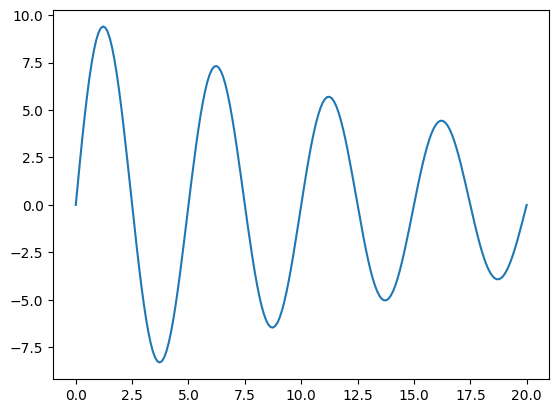

In [131]:
t, z = data_gen(200)
plt.plot(t,z)

## split and load data

In [132]:
class spring_mass_data(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    
dataset = spring_mass_data(t, z)
len(dataset)

200

In [133]:
train_set, test_set = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_set, batch_size = 17, shuffle = True)
test_loader = DataLoader(test_set)

## Define FFNN

In [134]:
class Net(nn.Module):
    def __init__(self, num_1):
        super().__init__()
        self.fc1 = nn.Linear(1, num_1)
        self.fc2 = nn.Linear(num_1, 1)
    
    def forward(self, input):
        f1 = self.fc1(input)
        a1 = nn.Tanh()(f1)
        f2 = self.fc2(a1)
        return f2
net = Net(100)
print(net)
params = list(net.parameters())
params[2].shape

Net(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


torch.Size([1, 100])

## Define loss fun and optimizer

In [135]:
loss_fun = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-2)

## Training loop

In [136]:
num_epoch = 10000
loss_hist = []
test_loss_hist = []
for epoch in range(num_epoch):
    for batch_inputs, batch_outputs in train_loader:
        
        optimizer.zero_grad()
        
        preds = net(batch_inputs)
        
        loss = loss_fun(preds, batch_outputs)
        
        loss.backward()
        
        optimizer.step()
    
    test_loss = 0.
    with torch.no_grad():
        for test_inputs, test_outputs in test_loader:
            test_preds = net(test_inputs)
            test_loss += loss_fun(test_preds, test_outputs).item()
    loss_hist.append(loss.item())
    test_loss_hist.append(test_loss)
    if epoch % 200 ==0:
        print(f"epoch is {epoch}, training loss is {loss.item()}, test loss is {test_loss}")

epoch is 0, training loss is 20.045595169067383, test loss is 721.9050668589771
epoch is 200, training loss is 3.2190778255462646, test loss is 386.06270612665685
epoch is 400, training loss is 13.63733196258545, test loss is 331.52597453056865
epoch is 600, training loss is 1.6042091846466064, test loss is 256.06307430154993
epoch is 800, training loss is 4.446981430053711, test loss is 215.70853058435023
epoch is 1000, training loss is 2.953939199447632, test loss is 254.4177631907005
epoch is 1200, training loss is 4.798613548278809, test loss is 192.2481289578136
epoch is 1400, training loss is 5.6946306228637695, test loss is 193.47937493489007
epoch is 1600, training loss is 0.16999831795692444, test loss is 106.53063092567027
epoch is 1800, training loss is 1.533669352531433, test loss is 103.97571949043777
epoch is 2000, training loss is 1.0324898958206177, test loss is 40.62914916614682
epoch is 2200, training loss is 0.16561497747898102, test loss is 38.157486699405126
epoch 

## Visualize results

Text(0, 0.5, 'Loss')

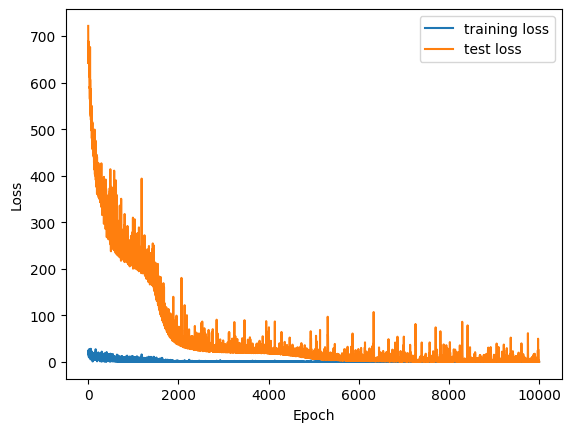

In [151]:
plt.plot(loss_hist, label = 'training loss')
plt.plot(test_loss_hist, label = 'test loss')
plt.legend()    
plt.xlabel('Epoch')
plt.ylabel('Loss')

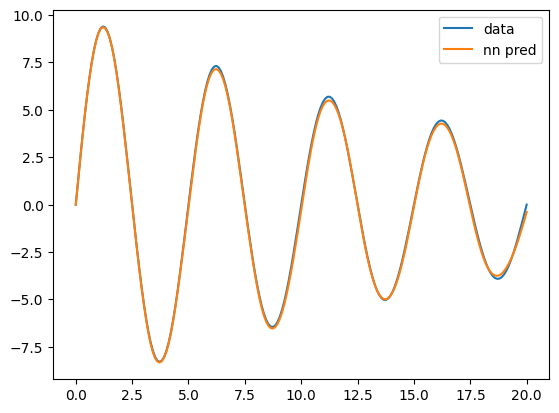

In [148]:
t_tensor = torch.tensor(t)
z_pred = net(t_tensor)

plt.plot(t,z,label = 'data')

plt.plot(t_tensor.detach().numpy(), z_pred.detach().numpy(), label = 'nn pred')
plt.legend()